In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

 94% 151M/161M [00:01<00:00, 134MB/s]
100% 161M/161M [00:01<00:00, 141MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/corn-or-maize-leaf-disease-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/data',
    shuffle = True,
    image_size = (256,256),
    batch_size = 32
)

Found 4188 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
len(dataset)

131

In [ ]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 2 2 0 2 3 0 1 1 1 1 3 1 0 0 1 1 1 2 3 1 1 3 0 2 1 1 3 3 1]


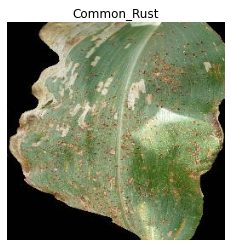

In [ ]:
import matplotlib.pyplot as plt
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.title(class_names[label_batch[0]])
  plt.axis('off')

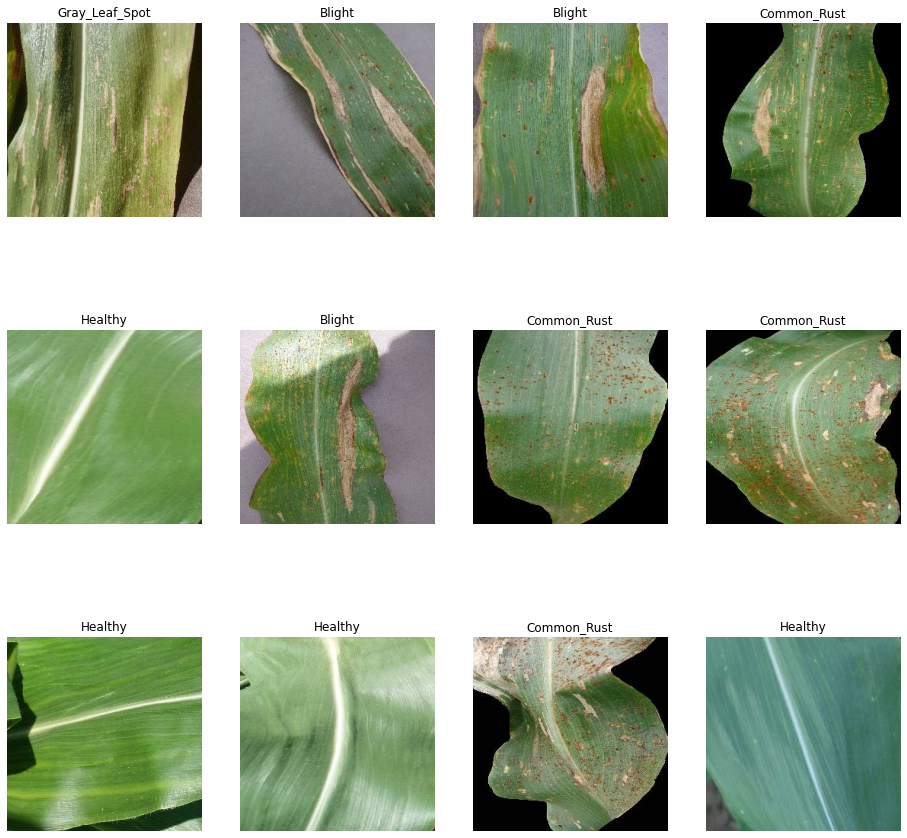

In [ ]:
plt.figure(figsize=(16,16))
for image_batch, label_batch in dataset.take(1):
  for i in range (12):
    leaf = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [ ]:
# splitting using creating function
def get_dataset_partitions_tf(ds,train_split =0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size =10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed =12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)
  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_data, val_data, test_data = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_data)

104

In [ ]:
len(test_data)

14

In [ ]:
len(val_data)

13

In [ ]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = (32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])
model.build(input_shape = (32,256,256,3))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    epochs = 10,
    batch_size = 32,
    verbose = 1,
    validation_data = val_data
)

Epoch 1/10
104/104 [==============================] - 35s 177ms/step - loss: 0.7697 - accuracy: 0.6742 - val_loss: 0.4759 - val_accuracy: 0.8149
Epoch 2/10
104/104 [==============================] - 9s 89ms/step - loss: 0.4631 - accuracy: 0.8168 - val_loss: 0.3893 - val_accuracy: 0.8341
Epoch 3/10
104/104 [==============================] - 9s 90ms/step - loss: 0.3783 - accuracy: 0.8436 - val_loss: 0.3788 - val_accuracy: 0.8438
Epoch 4/10
104/104 [==============================] - 9s 89ms/step - loss: 0.3481 - accuracy: 0.8601 - val_loss: 0.3600 - val_accuracy: 0.8413
Epoch 5/10
104/104 [==============================] - 9s 90ms/step - loss: 0.4124 - accuracy: 0.8439 - val_loss: 0.3577 - val_accuracy: 0.8486
Epoch 6/10
104/104 [==============================] - 9s 90ms/step - loss: 0.3327 - accuracy: 0.8616 - val_loss: 0.3144 - val_accuracy: 0.8798
Epoch 7/10
104/104 [==============================] - 9s 90ms/step - loss: 0.3259 - accuracy: 0.8727 - val_loss: 0.3087 - val_accuracy: 0.87

In [ ]:
scores= model.evaluate(test_data)

14/14 [==============================] - 7s 33ms/step - loss: 0.2716 - accuracy: 0.8951


In [ ]:
history.history['accuracy']

[0.6741877198219299,
 0.8167870044708252,
 0.8435619473457336,
 0.8601083159446716,
 0.8438628315925598,
 0.8616124987602234,
 0.8727436661720276,
 0.8718411326408386,
 0.8784596920013428,
 0.883273184299469]

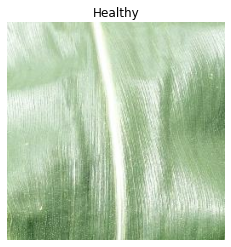

In [ ]:
for image_batch , label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.title(class_names[label_batch[0]])
  plt.axis('off')

The image to predict
Actual_label: Common_Rust
1/1 [==============================] - 0s 133ms/step
Predicted label: Common_Rust


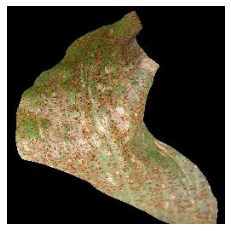

In [ ]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print('The image to predict')
  plt.imshow(first_image)
  print('Actual_label:', class_names[first_label])

  batch_prediction = model.predict(image_batch)
  pred_label = np.argmax(batch_prediction[0])
  print('Predicted label:', class_names[pred_label])
  plt.axis('off')

In [ ]:
def predict (model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) # create a batch

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class , confidence

1/1 [==============================] - 0s 15ms/step


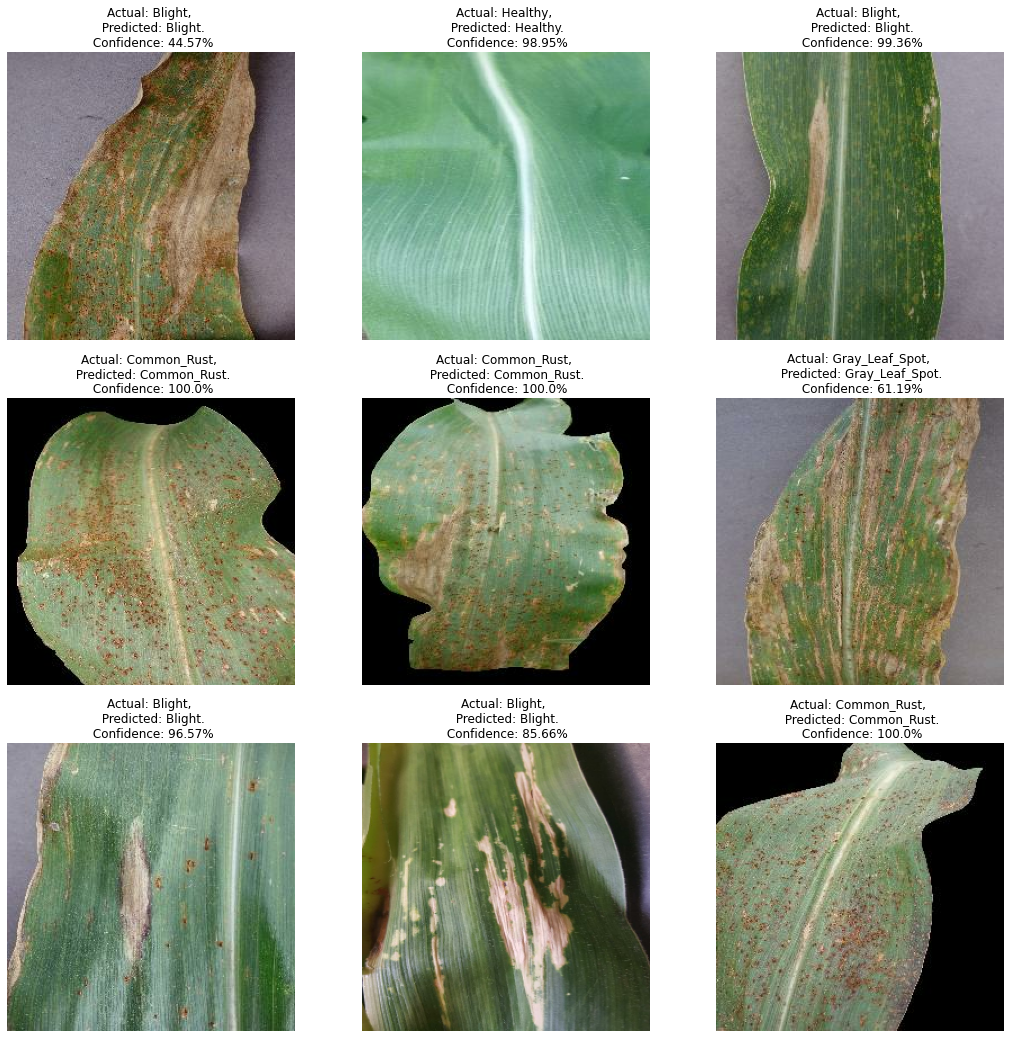

In [ ]:
plt.figure(figsize=(18,18))
for images, labels in test_data.take(1):
  for i in range (9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class , confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%')

    plt.axis('off')


In [ ]:
tf.keras.models.save_model(model, 'corn.pbtxt')
converter = tf.lite.TFLiteConverter.from_keras_model(model = model)
model_tflite = converter.convert()
open("CornDisease.tflite","wb").write(model_tflite)

741920